In [1]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
from fbprophet import Prophet

In [2]:
import warnings
import logging
warnings.filterwarnings('ignore')
tracer = logging.getLogger()
tracer.setLevel(logging.CRITICAL) # or desired level

In [3]:
df = pd.read_csv('gbpusd.csv', parse_dates=['Date'], dayfirst=True)
df.rename(columns={
    'GBP/USD Close':'y',
    'Date':'ds'}, inplace=True)
df.head()

,ds,y
0,1998-12-31,1.6604
1,1999-01-01,1.6604
2,1999-01-04,1.6560
3,1999-01-05,1.6547
4,1999-01-06,1.6544


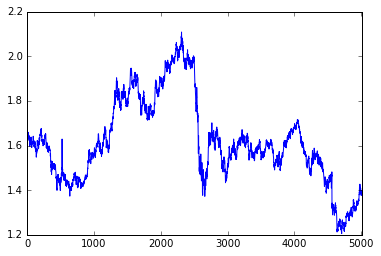

In [4]:
df['y'].plot()

In [5]:
end_period = len(df)
# Imagine we run this for two years
test_duration = 365*2
start_period = end_period - test_duration
print(start_period)

4282


In [6]:
def ret_predict_direction(dta):
    # Re-train every time period
    m = Prophet()
    # Train
    m.fit(dta)
    # Predict
    future = m.make_future_dataframe(periods=6)
    forecast = m.predict(future)
    # Take diff between prediction for today and last_period
    five_ahead = forecast['yhat'][-6:].values
    predicted_direction = five_ahead[-1]-five_ahead[0]
    return predicted_direction

In [7]:
def rule(position, predicted_direction):
    if (predicted_direction>0.005) and position=="none":
        return "buy"
    elif (predicted_direction<0.0005) and position=="long":
        return "sell"
    elif (predicted_direction<-0.005) and position=="none":
        return "short_sell"
    elif (predicted_direction>-0.0005) and position=="short_sell":
        return "close_short_sell"
    elif position=="long":
        return "keep long"
    elif position=="short_sell":
        return "keep short"
    else:
        return "none"

In [8]:
# Set variables
position = "none"
# Leverage is 200:1 and amount entry is 100 so effective is 20000
leverage = 200  # two mini lots on FXCM is £20k and costs £100 to enter
amount_in_pounds = 100
effective_amount = leverage*amount_in_pounds
profit_loss = 0
bought_at = 0
account = 1000 # imagine we start account with £1000
all_advice = []
all_balance = []
spread = 0.0003  # 3 point spread 
margin_call = 500

In [9]:
%%time
# Run simulation
# I'm not considering short-shelling which we can do
for period in range(start_period, end_period-6):
    # Assume we run this every morning on all data upto
    # and including yesterday
    # Then we assume market today opens at yesterday's close
    # So we buy/sell yesterday's close = today's open
    period_data = df[:period-1]
    # Generate prediction on what to do
    advice = rule(position, ret_predict_direction(period_data))
    #print("Advice: ", advice)
    all_advice.append(advice)
    all_balance.append(account)
    if account <= margin_call:
        print("GAME OVER!")
    # Perform trade
    # Enter positions
    if advice == "buy":
        # Enter long position
        bought_at = period_data.tail(1)['y'].values[0]
        print("Buy at %.4f" % bought_at)
        position = "long"
    elif advice == "short_sell":
        # Enter short position
        bought_at = period_data.tail(1)['y'].values[0]
        print("Short at %.4f" % bought_at)
        position = "short_sell"
    # Close positions
    elif advice == "sell":
        # Close long
        sell_at = period_data.tail(1)['y'].values[0]
        print("Sold at %.4f" % sell_at)
        profit_loss = (effective_amount*(sell_at - bought_at - spread)) 
        account += profit_loss
        position = "none"
        print("P/L from trade: %.2f" % profit_loss)
        print("Balance: %.2f" % account)
    elif advice == "close_short_sell":
        # Close short
        sell_at = period_data.tail(1)['y'].values[0]
        print("Leave short at %.4f" % sell_at)
        profit_loss = (effective_amount*(bought_at - sell_at - spread))
        account += profit_loss
        position = "none"
        print("P/L from trade: %.2f" % profit_loss)
        print("Balance: %.2f" % account)

Buy at 1.5196
Sold at 1.5267
P/L from trade: 136.00
Balance: 1136.00
Buy at 1.5340
Sold at 1.5552
P/L from trade: 418.00
Balance: 1554.00
Buy at 1.5606
Sold at 1.5648
P/L from trade: 78.00
Balance: 1632.00
Short at 1.5871
Leave short at 1.5815
P/L from trade: 105.20
Balance: 1737.20
Short at 1.5739
Leave short at 1.5727
P/L from trade: 18.00
Balance: 1755.20
Buy at 1.5604
Sold at 1.5513
P/L from trade: -188.00
Balance: 1567.20
Buy at 1.5489
Sold at 1.5611
P/L from trade: 238.00
Balance: 1805.20
Buy at 1.5564
Sold at 1.5622
P/L from trade: 110.00
Balance: 1915.20
Short at 1.5490
Leave short at 1.5586
P/L from trade: -198.00
Balance: 1717.20
Short at 1.5645
Leave short at 1.5590
P/L from trade: 104.40
Balance: 1821.60
Short at 1.5689
Leave short at 1.5759
P/L from trade: -146.20
Balance: 1675.40
Short at 1.5398
Leave short at 1.5351
P/L from trade: 88.80
Balance: 1764.20
Buy at 1.5283
Sold at 1.5424
P/L from trade: 276.00
Balance: 2040.20
Buy at 1.5425
Sold at 1.5528
P/L from trade: 201.

KeyboardInterrupt: 

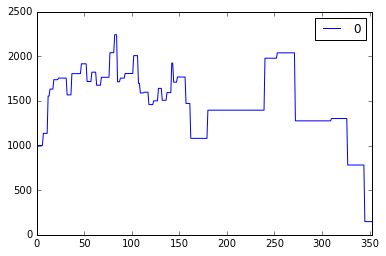

In [13]:
pd.DataFrame(all_balance).plot()